In [8]:
import pandas as pd
from collections import Counter
import itertools
import copy
import matplotlib.pyplot as plt


In [51]:
# Step 2's functions:
## Gale-Shapley Algorithm best to recipients:
def gale_shapley_1(don_pre, reci_pre):
    don_available = {recipient: donors_names[:] for recipient in recipients_names}
    waiting_list = []
    proposals = {}
    
    while len(waiting_list) < len(recipients_names):
        for recipient in recipients_names:
            if recipient not in waiting_list:
                donor = don_available[recipient]
                best_choice = reci_pre.loc[recipient][reci_pre.loc[recipient].index.isin(donor)].idxmin()
                proposals[(recipient, best_choice)] = (reci_pre.loc[recipient][best_choice], don_pre.loc[best_choice][recipient])
        
        overlays = Counter([key[1] for key in proposals.keys()])
        
        for donor in overlays.keys():
            if overlays[donor] > 1:
                pairs_to_drop = sorted({pair: proposals[pair] for pair in proposals.keys() if donor in pair}.items(), key=lambda x: x[1][1])[1:]
                for p_to_drop in pairs_to_drop:
                    del proposals[p_to_drop[0]]
                    _donor = copy.copy(don_available[p_to_drop[0][0]])
                    _donor.remove(p_to_drop[0][1])
                    don_available[p_to_drop[0][0]] = _donor
        
        waiting_list = [recipient[0] for recipient in proposals.keys()]
    
    return proposals

## Gale-Shapley Algorithm reversed:
def gale_shapley_2(reci_pre, don_pre):
    reci_available = {donor: recipients_names[:] for donor in donors_names}
    waiting_list = []
    proposals = {}
    
    while len(waiting_list) < len(donors_names):
        for donor in donors_names:
            if donor not in waiting_list:
                recipient = reci_available[donor]
                best_choice = don_pre.loc[donor][don_pre.loc[donor].index.isin(recipient)].idxmin()
                proposals[(donor, best_choice)] = (don_pre.loc[donor][best_choice], reci_pre.loc[best_choice][donor])
        
        overlays = Counter([key[1] for key in proposals.keys()])
        
        for recipient in overlays.keys():
            if overlays[recipient] > 1:
                pairs_to_drop = sorted({pair: proposals[pair] for pair in proposals.keys() if recipient in pair}.items(), key=lambda x: x[1][1])[1:]
                for p_to_drop in pairs_to_drop:
                    del proposals[p_to_drop[0]]
                    _recipient = copy.copy(reci_available[p_to_drop[0][0]])
                    _recipient.remove(p_to_drop[0][1])
                    reci_available[p_to_drop[0][0]] = _recipient
        
        waiting_list = [donor[0] for donor in proposals.keys()]
    
    return proposals

# Step 3's functions:
# Check mutual exclusion and remove items that cannot be paired in any stable match
def check_and_remove_exclusivity(filtered_reci_pre, filtered_don_pre):
    # Remove donor who is not in the recipient's list of preferences
    for r, donors in filtered_reci_pre.items():
        for d in donors[:]:
            if r not in filtered_don_pre[d]:
                filtered_reci_pre[r].remove(d)

    # # Remove recipient who is not in the recipient's preference list
    for d, recipients in filtered_don_pre.items():
        for r in recipients[:]:
            if d not in filtered_reci_pre[r]:
                filtered_don_pre[d].remove(r)

    return filtered_reci_pre, filtered_don_pre

# Function that rearranges the preference list in order of the matrix
def reorder_preference(pref_dict, pref_matrix):
    reordered_dict = {}
    for key, values in pref_dict.items():
        reordered_dict[key] = sorted(values, key=lambda x: pref_matrix.loc[key, x])
    return reordered_dict

# Step 4's functions:
def find_closed_cycles(filtered_reci_pre, max_length=10):
    # Create empty lists to store cycles and closed cycles
    cycle = []
    closed_cycles = []

    # First step: Create initial lists for recipients with preference lists longer than 1
    for r in filtered_reci_pre:
        if len(filtered_reci_pre[r]) > 1:
            # Initialize the list with the recipient and their second preferred donor
            initial_list = [r, filtered_reci_pre[r][1]]
            cycle.append(initial_list)
    # print(cycle)

    # Loop until cycle is empty
    while cycle:
        new_cycle = []  # To store new lists generated in each iteration

        # Check each list in cycle
        for lst in cycle[:]:  # Use a copy of cycle to modify the original
            # First, check if the list forms a closed cycle
            if lst[0] == lst[-1]:
                closed_cycles.append(lst)  # Store the closed cycle
                cycle.remove(lst)  # Remove from cycle
            elif len(lst) > max_length:
                # Remove lists that exceed maximum allowed length
                cycle.remove(lst)
            elif len(set(lst)) < len(lst):
                # Remove lists with repeated recipients/donors (excluding the case where start and end are the same)
                cycle.remove(lst)
            else:
                if len(lst) % 2 == 1:  # If the list length is odd
                    last_recip = lst[-1]
                    if len(filtered_reci_pre[last_recip]) > 1:
                        next_donor = filtered_reci_pre[last_recip][1]  # Take the second preference
                        lst.append(next_donor)  # Extend the list
                elif len(lst) % 2 == 0:  # If the list length is even
                    last_donor = lst[-1]
                    found = False
                    # Find recipients whose first preference matches the last donor
                    for recip, preferences in filtered_reci_pre.items():
                        if preferences[0] == last_donor:
                            new_list = lst + [recip]
                            new_cycle.append(new_list)
                            found = True
                    cycle.remove(lst)  # Remove the original list
                    if not found:
                        # If no matching recipient found, do nothing (lst already removed)
                        pass

        # Add new lists to cycle
        cycle.extend(new_cycle)

    return closed_cycles

# Remove duplicate cycles
def remove_duplicates(lists):
    seen = set()
    result = []

    for lst in lists:
        # Convert the list to a tuple of tuples to make it hashable
        lst_tuple = tuple(lst)
        if lst_tuple not in seen:
            result.append(lst)
            seen.add(lst_tuple)

    return result


def remove_duplicate_cycles(cycles):
    unique_cycles = {}
    for cycle in cycles:
        # Convert the cycle to a frozenset to identify unique sets
        cycle_set = frozenset(cycle)
        if cycle_set not in unique_cycles:
            # Store the original cycle corresponding to the unique set
            unique_cycles[cycle_set] = cycle
    # Return the original cycles corresponding to the unique sets
    return list(unique_cycles.values())

# Step 5's function:
def update_matching(mu_R, output_lists, reci_pre_matrix, don_pre_matrix):
    # Creates a list to store all new matches

    matchings = []
    
    # Iterate over the lists in output_lists one by one
    for lst in output_lists:
        # Copy the current match and prepare to update
        new_mu_R = mu_R.copy()
        
        # Parses the list one by one, matching r and d in pairs
        for i in range(0, len(lst) - 1, 2):
            r = lst[i]
            d = lst[i + 1]
            
            # Gets the ordinal of r's preference for a
            r_preference = reci_pre_matrix.loc[r, d]
            
            # Gets the ordinal preference of a over r
            d_preference = don_pre_matrix.loc[d, r]
            
            # Generates a new pair and replaces the pair containing this r in the original mu_R
            new_mu_R[(r, d)] = (r_preference, d_preference)
            
            # Delete old pairs that contain r
            for key in list(new_mu_R.keys()):
                if key[0] == r and key[1] != d:
                    del new_mu_R[key]
        
        # Adds the new match to the matchings list
        matchings.append(new_mu_R.copy())
    
    return matchings

# Step 6's functions:
def combine_matchings(matchings, reci_pre_matrix):
    # Initialize the new matching
    combined_matching = {}

    # Get the list of all recipients
    recipients = reci_pre_matrix.index

    # For each recipient, select a donor from the combined matchings
    for recipient in recipients:
        worst_donor = None
        worst_preference = -1  # Higher preference value means the recipient likes the donor less
        matching_with_worst_donor = None  # To store the matching containing the worst donor

        # Iterate over all matchings
        for matching in matchings:
            for (r, d), (r_pref, _) in matching.items():
                if r == recipient and r_pref > worst_preference:
                    worst_preference = r_pref
                    worst_donor = (r, d)
                    matching_with_worst_donor = matching  # Record the matching containing this pair

        # Check if a worst donor was found and add it to the combined matching
        if worst_donor:
            combined_matching[worst_donor] = (worst_preference, matching_with_worst_donor[worst_donor][1])
        else:
            print(f"No valid donor found for recipient {recipient}")

    return combined_matching


def generate_pairwise_combinations_and_combine(matchings, reci_pre_matrix):
    all_combined_matchings = []

    # Generate all possible pairwise combinations of matchings
    for combination in itertools.combinations(matchings, 2):
        print(f"Combining 2 matchings: {combination}")
        # Combine the two matchings into a new matching
        new_matching = combine_matchings(combination, reci_pre_matrix)
        if new_matching:
            all_combined_matchings.append(new_matching)

    return all_combined_matchings

def add_unique_matchings(all_combined_matchings, stable_matching):
    # Convert each matching in stable_matching to a frozenset to compare
    stable_set = {frozenset(matching.items()) for matching in stable_matching}

    # Iterate over all_combined_matchings and check for duplicates
    for matching in all_combined_matchings:
        matching_frozenset = frozenset(matching.items())  # Convert current matching to frozenset
        if matching_frozenset not in stable_set:
            stable_matching.append(matching)  # Add the non-duplicate matching
            stable_set.add(matching_frozenset)  # Update the stable_set


def update_filtered_preference_lists(final_matching, filtered_reci_pre, filtered_don_pre, reci_pre_matrix, don_pre_matrix):
    # Update recipients' preference lists
    for (recipient, donor), (r_pref, _) in final_matching.items():
        # Get the recipient's current list of preferred donors
        filtered_donors = filtered_reci_pre[recipient]
        # Remove donors that the recipient prefers more than the matched donor
        filtered_reci_pre[recipient] = [d for d in filtered_donors if reci_pre_matrix.loc[recipient, d] >= r_pref]

    # Update donors' preference lists
    for (recipient, donor), (_, d_pref) in final_matching.items():
        # Get the donor's current list of preferred recipients
        filtered_recipients = filtered_don_pre[donor]
        # Remove recipients that the donor prefers less than the matched recipient
        filtered_don_pre[donor] = [r for r in filtered_recipients if don_pre_matrix.loc[donor, r] <= d_pref]

    return filtered_reci_pre, filtered_don_pre

def check_and_remove_exclusivity(filtered_reci_pre, filtered_don_pre):
    # Remove donors not in the donor's preference list
    for r, donors in filtered_reci_pre.items():
        for d in donors[:]:  # Use a copy to avoid modifying the list while iterating
            if r not in filtered_don_pre[d]:
                filtered_reci_pre[r].remove(d)

    # Remove recipients not in the recipient's preference list
    for d, recipients in filtered_don_pre.items():
        for r in recipients[:]:  # Use a copy to avoid modifying the list while iterating
            if d not in filtered_reci_pre[r]:
                filtered_don_pre[d].remove(r)

    return filtered_reci_pre, filtered_don_pre

# Convert the dictionary to frozenset to detect duplicates and remove duplicates
def remove_duplicate_dicts(all_new_matchings):
    unique_matchings = []
    seen = set()  # Record matches that have already occurred

    for matching in all_new_matchings:
        # Turn dictionary entries into Frozensets so you can hash and compare them
        matching_frozenset = frozenset(matching.items())
        
        # If the match does not occur, it is added to unique_matchings
        if matching_frozenset not in seen:
            unique_matchings.append(matching)
            seen.add(matching_frozenset)

    return unique_matchings

def update_stable_matching(stable_matching, mu_D):
    # Marks whether mu_D already exists in any dictionary in stable_matching
    is_duplicate = False

    # Traverse each dictionary in stable_matching
    for match in stable_matching:
        # Traverse each pair in mu_D
        for donor_recipient, value in mu_D.items():
            # Inverts mu_D's key (donor, recipient) to match stable_matching (recipient, donor)
            recipient_donor = (donor_recipient[1], donor_recipient[0])
            
            # If a matching recipient-donor pair is found, it is marked as duplicate
            if recipient_donor in match:
                is_duplicate = True
                break
        if is_duplicate:
            break
    
    # If there is no duplicate mu_D, add mu_D to stable_matching
    if not is_duplicate:
        stable_matching.append(mu_D)
    else:
        print(f'Donor stable matching, mu_D, exists in stable_matching.')

    return stable_matching

In [52]:
# replaces r with m and d with w
def replace_keys_in_matchings(matchings):
    new_matchings = []
    for matching in matchings:
        new_dict = {}
        for (r, d), val in matching.items():
            new_r = r.replace('r', 'm')
            new_d = d.replace('d', 'w')
            new_dict[(new_r, new_d)] = val
        new_matchings.append(new_dict)
    return new_matchings

# Use pandas to convert each match into a table
def create_aggregate_table(matchings):
    men = [f'm{i}' for i in range(1, len(recipients_names)+1)]
    df = pd.DataFrame({'Man': men})
    
    for i, matching in enumerate(matchings):
        col = {}
        for (man, woman), val in matching.items():
            col[man] = woman
        df[f'μ{i+1}'] = df['Man'].map(col)
    
    return df


In [53]:
# Check the stability of each matching in stable_matching
def find_all_instabilities(matching, reci_pre, don_pre):
    matching_dict = {donor: recipient for donor, recipient in matching}
    instabilities = {}

    for donor, recipient in matching_dict.items():
        # Index of the recipient in the donor's preference list
        matched_recipient_rank = don_pre.loc[donor, recipient]
        donor_preferences = don_pre.loc[donor]

        # Check all recipients above the matched recipient in donor's preferences
        preferred_recipients = donor_preferences[donor_preferences < matched_recipient_rank].index.tolist()

        for other_recipient in preferred_recipients:
            # Find the other donor matched to the other recipient
            other_donor_list = [d for d, r in matching if r == other_recipient]
            if other_donor_list:
                other_donor = other_donor_list[0]

                # If the other recipient prefers this donor over their current match
                if reci_pre.loc[other_recipient, donor] < reci_pre.loc[other_recipient, other_donor]:
                    donor_preference_score = don_pre.loc[donor, other_recipient]
                    recipient_preference_score = reci_pre.loc[other_recipient, donor]
                    instabilities[(donor, other_recipient)] = (donor_preference_score, recipient_preference_score)
    
    return instabilities

In [1]:
# Step 1: Define recipients and donors' preference lists

import numpy as np
import pandas as pd
import random

def generate_random_permutation(n):
    return np.random.permutation(n)

random.seed(0)
# Sample data
donors_names = ['d' + str(i) for i in range(1, 101)]
recipients_names = ['r' + str(i) for i in range(1, 101)]

# Randomly scramble the names of donors and recipients
np.random.shuffle(donors_names)
np.random.shuffle(recipients_names)

# Create an initial matching
initial_match = list(zip(donors_names, recipients_names))

# Construct example data for don_pre and reci_pre
# Generate reci_pre data frame
reci_pre_arry = np.array([generate_random_permutation(100) for _ in range(100)])
reci_pref_matrix = pd.DataFrame(reci_pre_arry, index=recipients_names, columns=donors_names)

# Generate don_pre data frame
don_pre_arry = np.array([generate_random_permutation(100) for _ in range(100)])
don_pref_matrix = pd.DataFrame(don_pre_arry, index=donors_names, columns=recipients_names)



In [63]:
# Step 2: Gale-Shapley algorithm implementation

stable_matching = []

recipients_names = reci_pref_matrix.index.tolist()
donors_names = don_pref_matrix.index.tolist()

# Find the optimal match for recipients
mu_R = gale_shapley_1(don_pref_matrix, reci_pref_matrix)
# Find an optimal match for donors
mu_D = gale_shapley_2(reci_pref_matrix, don_pref_matrix)
stable_matching.append(mu_R)

print("recipients optimal stable matching:", mu_R)
print("donors optimal matching:", mu_D)
stable_matching

recipients optimal stable matching: {('r76', 'd27'): (0, 27), ('r40', 'd11'): (0, 42), ('r93', 'd13'): (0, 2), ('r75', 'd86'): (0, 15), ('r96', 'd77'): (0, 3), ('r34', 'd4'): (0, 83), ('r77', 'd78'): (0, 6), ('r89', 'd40'): (0, 58), ('r85', 'd88'): (0, 31), ('r18', 'd99'): (0, 55), ('r83', 'd63'): (0, 47), ('r52', 'd10'): (0, 22), ('r3', 'd60'): (0, 10), ('r78', 'd82'): (0, 89), ('r68', 'd80'): (0, 4), ('r67', 'd57'): (0, 48), ('r55', 'd54'): (0, 11), ('r59', 'd72'): (0, 28), ('r32', 'd83'): (0, 57), ('r38', 'd70'): (0, 5), ('r35', 'd21'): (0, 79), ('r26', 'd31'): (0, 48), ('r11', 'd46'): (0, 3), ('r72', 'd18'): (1, 23), ('r87', 'd32'): (1, 6), ('r70', 'd29'): (1, 28), ('r81', 'd73'): (1, 54), ('r39', 'd5'): (1, 33), ('r42', 'd50'): (1, 25), ('r17', 'd42'): (1, 55), ('r97', 'd34'): (1, 5), ('r62', 'd7'): (1, 6), ('r46', 'd68'): (1, 6), ('r79', 'd92'): (1, 11), ('r47', 'd74'): (1, 17), ('r5', 'd87'): (1, 35), ('r90', 'd62'): (2, 3), ('r28', 'd38'): (2, 17), ('r94', 'd89'): (2, 21), ('r9

[{('r76', 'd27'): (0, 27),
  ('r40', 'd11'): (0, 42),
  ('r93', 'd13'): (0, 2),
  ('r75', 'd86'): (0, 15),
  ('r96', 'd77'): (0, 3),
  ('r34', 'd4'): (0, 83),
  ('r77', 'd78'): (0, 6),
  ('r89', 'd40'): (0, 58),
  ('r85', 'd88'): (0, 31),
  ('r18', 'd99'): (0, 55),
  ('r83', 'd63'): (0, 47),
  ('r52', 'd10'): (0, 22),
  ('r3', 'd60'): (0, 10),
  ('r78', 'd82'): (0, 89),
  ('r68', 'd80'): (0, 4),
  ('r67', 'd57'): (0, 48),
  ('r55', 'd54'): (0, 11),
  ('r59', 'd72'): (0, 28),
  ('r32', 'd83'): (0, 57),
  ('r38', 'd70'): (0, 5),
  ('r35', 'd21'): (0, 79),
  ('r26', 'd31'): (0, 48),
  ('r11', 'd46'): (0, 3),
  ('r72', 'd18'): (1, 23),
  ('r87', 'd32'): (1, 6),
  ('r70', 'd29'): (1, 28),
  ('r81', 'd73'): (1, 54),
  ('r39', 'd5'): (1, 33),
  ('r42', 'd50'): (1, 25),
  ('r17', 'd42'): (1, 55),
  ('r97', 'd34'): (1, 5),
  ('r62', 'd7'): (1, 6),
  ('r46', 'd68'): (1, 6),
  ('r79', 'd92'): (1, 11),
  ('r47', 'd74'): (1, 17),
  ('r5', 'd87'): (1, 35),
  ('r90', 'd62'): (2, 3),
  ('r28', 'd38'):

In [64]:
# Define functions for each step
def initial_step(mu_R, mu_D, reci_pref_matrix, don_pref_matrix):

    # Initial step: Generate updated preference sequences based on mu_R and mu_D, and then generate closed cycles based on these 
    # squences to produce new matchings

    # Screen eligible donors for each recipient
    filtered_reci_pre = {}
    for r, d in mu_R.keys():

        # Gets the ordinal of r's preference for matching donor in mu_R
        r_pref_muR = reci_pref_matrix.loc[r, d]
        
        # Obtain the donor for r matching in mu_D
        matching_donor_in_muD = [key[0] for key in mu_D.keys() if key[1] == r][0]
        r_pref_muD = reci_pref_matrix.loc[r, matching_donor_in_muD]

        # Screen eligible donors
        filtered_donors = reci_pref_matrix.columns[(reci_pref_matrix.loc[r] < r_pref_muR) | (reci_pref_matrix.loc[r] > r_pref_muD)].tolist()
        filtered_reci_pre[r] = filtered_donors

        # Remove ineligible donors
        filtered_reci_pre[r] = reci_pref_matrix.loc[r].drop(filtered_donors).index.tolist()

    # Screen eligible recipients for each donor d
    filtered_don_pre = {}
    for d, r in mu_D.keys():
        
        # Get d's preference ordinal for the matching recipient in mu_D
        d_pref_muD = don_pref_matrix.loc[d, r]
        
        # Get the d matching recipient in mu_R
        matching_recipient_in_muR = [key[0] for key in mu_R.keys() if key[1] == d][0]
        d_pref_muR = don_pref_matrix.loc[d, matching_recipient_in_muR]

        # Filter eligible recipients
        filtered_recipients = don_pref_matrix.columns[(don_pref_matrix.loc[d] < d_pref_muD) | (don_pref_matrix.loc[d] > d_pref_muR)].tolist()
        filtered_don_pre[d] = filtered_recipients

        # Delete recipients that do not qualify
        filtered_don_pre[d] = don_pref_matrix.loc[d].drop(filtered_recipients).index.tolist()


    # Call function to check mutual exclusion and update simplified preference list
    filtered_reci_pre1, filtered_don_pre1 = check_and_remove_exclusivity(filtered_reci_pre, filtered_don_pre)

    # Reorder the recipient preference order
    filtered_reci_pre = reorder_preference(filtered_reci_pre1, reci_pref_matrix)
    filtered_don_pre = reorder_preference(filtered_don_pre1, don_pref_matrix)

    closed_cycles = find_closed_cycles(filtered_reci_pre)
    output_lists = remove_duplicates(closed_cycles)
    output_lists = remove_duplicate_cycles(output_lists)

    new_matchings = update_matching(mu_R, output_lists, reci_pref_matrix, don_pref_matrix)
    for i in new_matchings:
        stable_matching.append(i)

    
    return new_matchings, filtered_reci_pre, filtered_don_pre

def step_b(prev_matchings, reci_pref_matrix):
    # Step b：Combine different pairs of stable matchings to obtain new stable matchings

    # Generate all new pairwise matching combinations
    new_matching = []
    new_matching = generate_pairwise_combinations_and_combine(prev_matchings, reci_pref_matrix)
    new_matchings = new_matching

    # Add unique matchings to stable_matching
    add_unique_matchings(new_matchings, stable_matching)

    # Print the generated new matchings
    for idx, matching in enumerate(new_matchings):
        print(f"New combined matching {idx + 1}:")
        print(matching)
    return new_matchings

def step_r(prev_matchings, filtered_reci_pre, filtered_don_pre, reci_pref_matrix, don_pref_matrix):
    # Step r：Each entry of new_matchings is used to update the recipients' and donors' preference lists filtered_reci_pre 
    # and filtered_don_pre, respectively, and generate a new stable match based on a closed loop

    # Initialize lists to store the updated preference lists after each update
    updated_filtered_reci_pre_list = []
    updated_filtered_don_pre_list = []
    all_new_matchings = []

    # Loop over each matching in new_matchings
    for idx, final_matching in enumerate(prev_matchings):
        print(f"Processing matching {idx + 1}:")
        
        # Make deep copies of the initial preference lists to avoid modifying the originals
        reci_pre_copy = copy.deepcopy(filtered_reci_pre)
        don_pre_copy = copy.deepcopy(filtered_don_pre)

        # Update the preference lists using the current matching
        updated_reci_pre, updated_don_pre = update_filtered_preference_lists(
            final_matching, reci_pre_copy, don_pre_copy, reci_pref_matrix, don_pref_matrix
        )

        # Check mutual exclusivity and remove impossible pairs
        updated_reci_pre, updated_don_pre = check_and_remove_exclusivity(updated_reci_pre, updated_don_pre)

        closed_cycles = find_closed_cycles(updated_reci_pre)
        output_lists = remove_duplicates(closed_cycles)
        output_lists = remove_duplicate_cycles(output_lists)
        per_new_matchings = update_matching(final_matching, output_lists, reci_pref_matrix, don_pref_matrix)
        for m in per_new_matchings:
            all_new_matchings.append(m)
        
        # Store the updated preference lists
        updated_filtered_reci_pre_list.append(updated_reci_pre)
        updated_filtered_don_pre_list.append(updated_don_pre)

        # Optionally, print the updated preference lists
        print(f"New matchings after matching {idx + 1}:")
        print(per_new_matchings)
        # print(f"Updated Donors Preference List after matching {idx + 1}:")
        # print(updated_don_pre)
        print("")  # Empty line for better readability

    # Remove duplicate dictionaries
    new_matchings = []
    new_matchings = remove_duplicate_dicts(all_new_matchings)
    for i in new_matchings:
        stable_matching.append(i)

    
    return new_matchings, updated_filtered_reci_pre_list, updated_filtered_don_pre_list


In [65]:
# Initialize variables
stable_matching = []  # List to store all stable matchings
stable_matching.append(mu_R)
after_step = 'Initial'
continue_loop = True

# Perform Initial Step
new_matchings, filtered_reci_pre, filtered_don_pre = initial_step(mu_R, mu_D, reci_pref_matrix, don_pref_matrix)
n = len(new_matchings)
stable_matching.extend(new_matchings)

if n == 0:
    continue_loop = False
elif n == 1:
    after_step = 'Ir'
elif n > 1:
    after_step = 'b'

# prev_matchings = new_matchings  # Initialize previous matchings

while continue_loop:
    if after_step == 'b':
        # Perform step b
        # new_matchings = step_b(prev_matchings, reci_pref_matrix)
        n = len(new_matchings)
        new_matchings = step_b(new_matchings, reci_pref_matrix)
        stable_matching.extend(new_matchings)
        n1 = len(new_matchings)

        if n1 == 0:
            continue_loop = False
            break

        # prev_matchings = new_matchings.copy()

        # Perform n-1 times step r
        for _ in range(n-1):
            # new_matchings, _, _ = step_r(prev_matchings, filtered_reci_pre, filtered_don_pre, reci_pref_matrix, don_pref_matrix)
            new_matchings, _, _ = step_r(new_matchings, filtered_reci_pre, filtered_don_pre, reci_pref_matrix, don_pref_matrix)
            n = len(new_matchings)
            stable_matching.extend(new_matchings)

            if n == 0:
                continue_loop = False
                break
        
            # prev_matchings = new_matchings.copy()
        n = len(new_matchings)
        after_step = 'cr'

    elif after_step == 'Ir':
        # Perform step r
        new_matchings, _, _ = step_r(new_matchings, filtered_reci_pre, filtered_don_pre, reci_pref_matrix, don_pref_matrix)
        n = len(new_matchings)
        stable_matching.extend(new_matchings)

        if n == 0:
            continue_loop = False
            break
        elif n == 1:
            after_step = 'Ir'
        elif n > 1:
            after_step = 'b'

        # prev_matchings = new_matchings.copy()

    elif after_step == 'cr':
        # Perform step b
        n = len(new_matchings)

        if n == 1:
            # Perform step r
            new_matchings, _, _ = step_r(new_matchings, filtered_reci_pre, filtered_don_pre, reci_pref_matrix, don_pref_matrix)
            n = len(new_matchings)
            stable_matching.extend(new_matchings)

            if n == 0:
                continue_loop = False
                break
            elif n == 1:
                after_step = 'Ir'
            elif n > 1:
                after_step = 'b'
        
        if n >= 2:
            # Perform step b
            new_matchings = step_b(new_matchings, reci_pref_matrix)
            stable_matching.extend(new_matchings)
            n1 = len(new_matchings)

            if n1 == 0:
                continue_loop = False
                break

            # prev_matchings = new_matchings.copy()
            after_step = 'b'
            # Perform n-1 times step r
            for _ in range(n - 1):
                new_matchings, _, _ = step_r(new_matchings, filtered_reci_pre, filtered_don_pre, reci_pref_matrix, don_pref_matrix)
                n = len(new_matchings)
                stable_matching.extend(new_matchings)

                if n == 0:
                    continue_loop = False
                    break

                    # prev_matchings = new_matchings.copy()
            n = len(new_matchings)
            after_step = 'cr'

    else:
        continue_loop = False

mu_D = { (key[1], key[0]): (value[1], value[0]) for key, value in mu_D.items() }
stable_matching = update_stable_matching(stable_matching, mu_D)
stable_matching = remove_duplicate_dicts(stable_matching)

Combining 2 matchings: ({('r76', 'd27'): (0, 27), ('r40', 'd11'): (0, 42), ('r93', 'd13'): (0, 2), ('r75', 'd86'): (0, 15), ('r96', 'd77'): (0, 3), ('r34', 'd4'): (0, 83), ('r77', 'd78'): (0, 6), ('r89', 'd40'): (0, 58), ('r85', 'd88'): (0, 31), ('r18', 'd99'): (0, 55), ('r83', 'd63'): (0, 47), ('r52', 'd10'): (0, 22), ('r3', 'd60'): (0, 10), ('r78', 'd82'): (0, 89), ('r68', 'd80'): (0, 4), ('r67', 'd57'): (0, 48), ('r55', 'd54'): (0, 11), ('r59', 'd72'): (0, 28), ('r32', 'd83'): (0, 57), ('r38', 'd70'): (0, 5), ('r35', 'd21'): (0, 79), ('r26', 'd31'): (0, 48), ('r11', 'd46'): (0, 3), ('r72', 'd18'): (1, 23), ('r87', 'd32'): (1, 6), ('r70', 'd29'): (1, 28), ('r81', 'd73'): (1, 54), ('r39', 'd5'): (1, 33), ('r42', 'd50'): (1, 25), ('r17', 'd42'): (1, 55), ('r97', 'd34'): (1, 5), ('r62', 'd7'): (1, 6), ('r46', 'd68'): (1, 6), ('r79', 'd92'): (1, 11), ('r47', 'd74'): (1, 17), ('r5', 'd87'): (1, 35), ('r90', 'd62'): (2, 3), ('r28', 'd38'): (2, 17), ('r94', 'd89'): (2, 21), ('r9', 'd81'): (

In [66]:
# Check the stability of each matching in stable_matching
all_stable = True

# Loop through each matching in the stable_matching list
for idx, matching in enumerate(stable_matching):

    formatted_matching = [(d, r) for (r, d), _ in matching.items()]

    # Call find_all_instabilities function to check for instabilities in the current matching
    instabilities = find_all_instabilities(formatted_matching, reci_pref_matrix, don_pref_matrix)

    # If instabilities are found, set the flag to False and output the details
    if instabilities:
        all_stable = False
        print(f"Instabilities found in matching {idx + 1}:")
        for pair, scores in instabilities.items():
            print(f"  Donor {pair[0]} prefers Recipient {pair[1]} with scores: {scores}")

# After checking all matchings, output if all were stable
if all_stable:
    print("All matchings are stable.")


All matchings are stable.


In [67]:
# Output the final stable matchings
print('We get',len(stable_matching), 'stable matchings:')
for matching in stable_matching:
    print(matching)

We get 6 stable matchings:
{('r76', 'd27'): (0, 27), ('r40', 'd11'): (0, 42), ('r93', 'd13'): (0, 2), ('r75', 'd86'): (0, 15), ('r96', 'd77'): (0, 3), ('r34', 'd4'): (0, 83), ('r77', 'd78'): (0, 6), ('r89', 'd40'): (0, 58), ('r85', 'd88'): (0, 31), ('r18', 'd99'): (0, 55), ('r83', 'd63'): (0, 47), ('r52', 'd10'): (0, 22), ('r3', 'd60'): (0, 10), ('r78', 'd82'): (0, 89), ('r68', 'd80'): (0, 4), ('r67', 'd57'): (0, 48), ('r55', 'd54'): (0, 11), ('r59', 'd72'): (0, 28), ('r32', 'd83'): (0, 57), ('r38', 'd70'): (0, 5), ('r35', 'd21'): (0, 79), ('r26', 'd31'): (0, 48), ('r11', 'd46'): (0, 3), ('r72', 'd18'): (1, 23), ('r87', 'd32'): (1, 6), ('r70', 'd29'): (1, 28), ('r81', 'd73'): (1, 54), ('r39', 'd5'): (1, 33), ('r42', 'd50'): (1, 25), ('r17', 'd42'): (1, 55), ('r97', 'd34'): (1, 5), ('r62', 'd7'): (1, 6), ('r46', 'd68'): (1, 6), ('r79', 'd92'): (1, 11), ('r47', 'd74'): (1, 17), ('r5', 'd87'): (1, 35), ('r90', 'd62'): (2, 3), ('r28', 'd38'): (2, 17), ('r94', 'd89'): (2, 21), ('r9', 'd81')

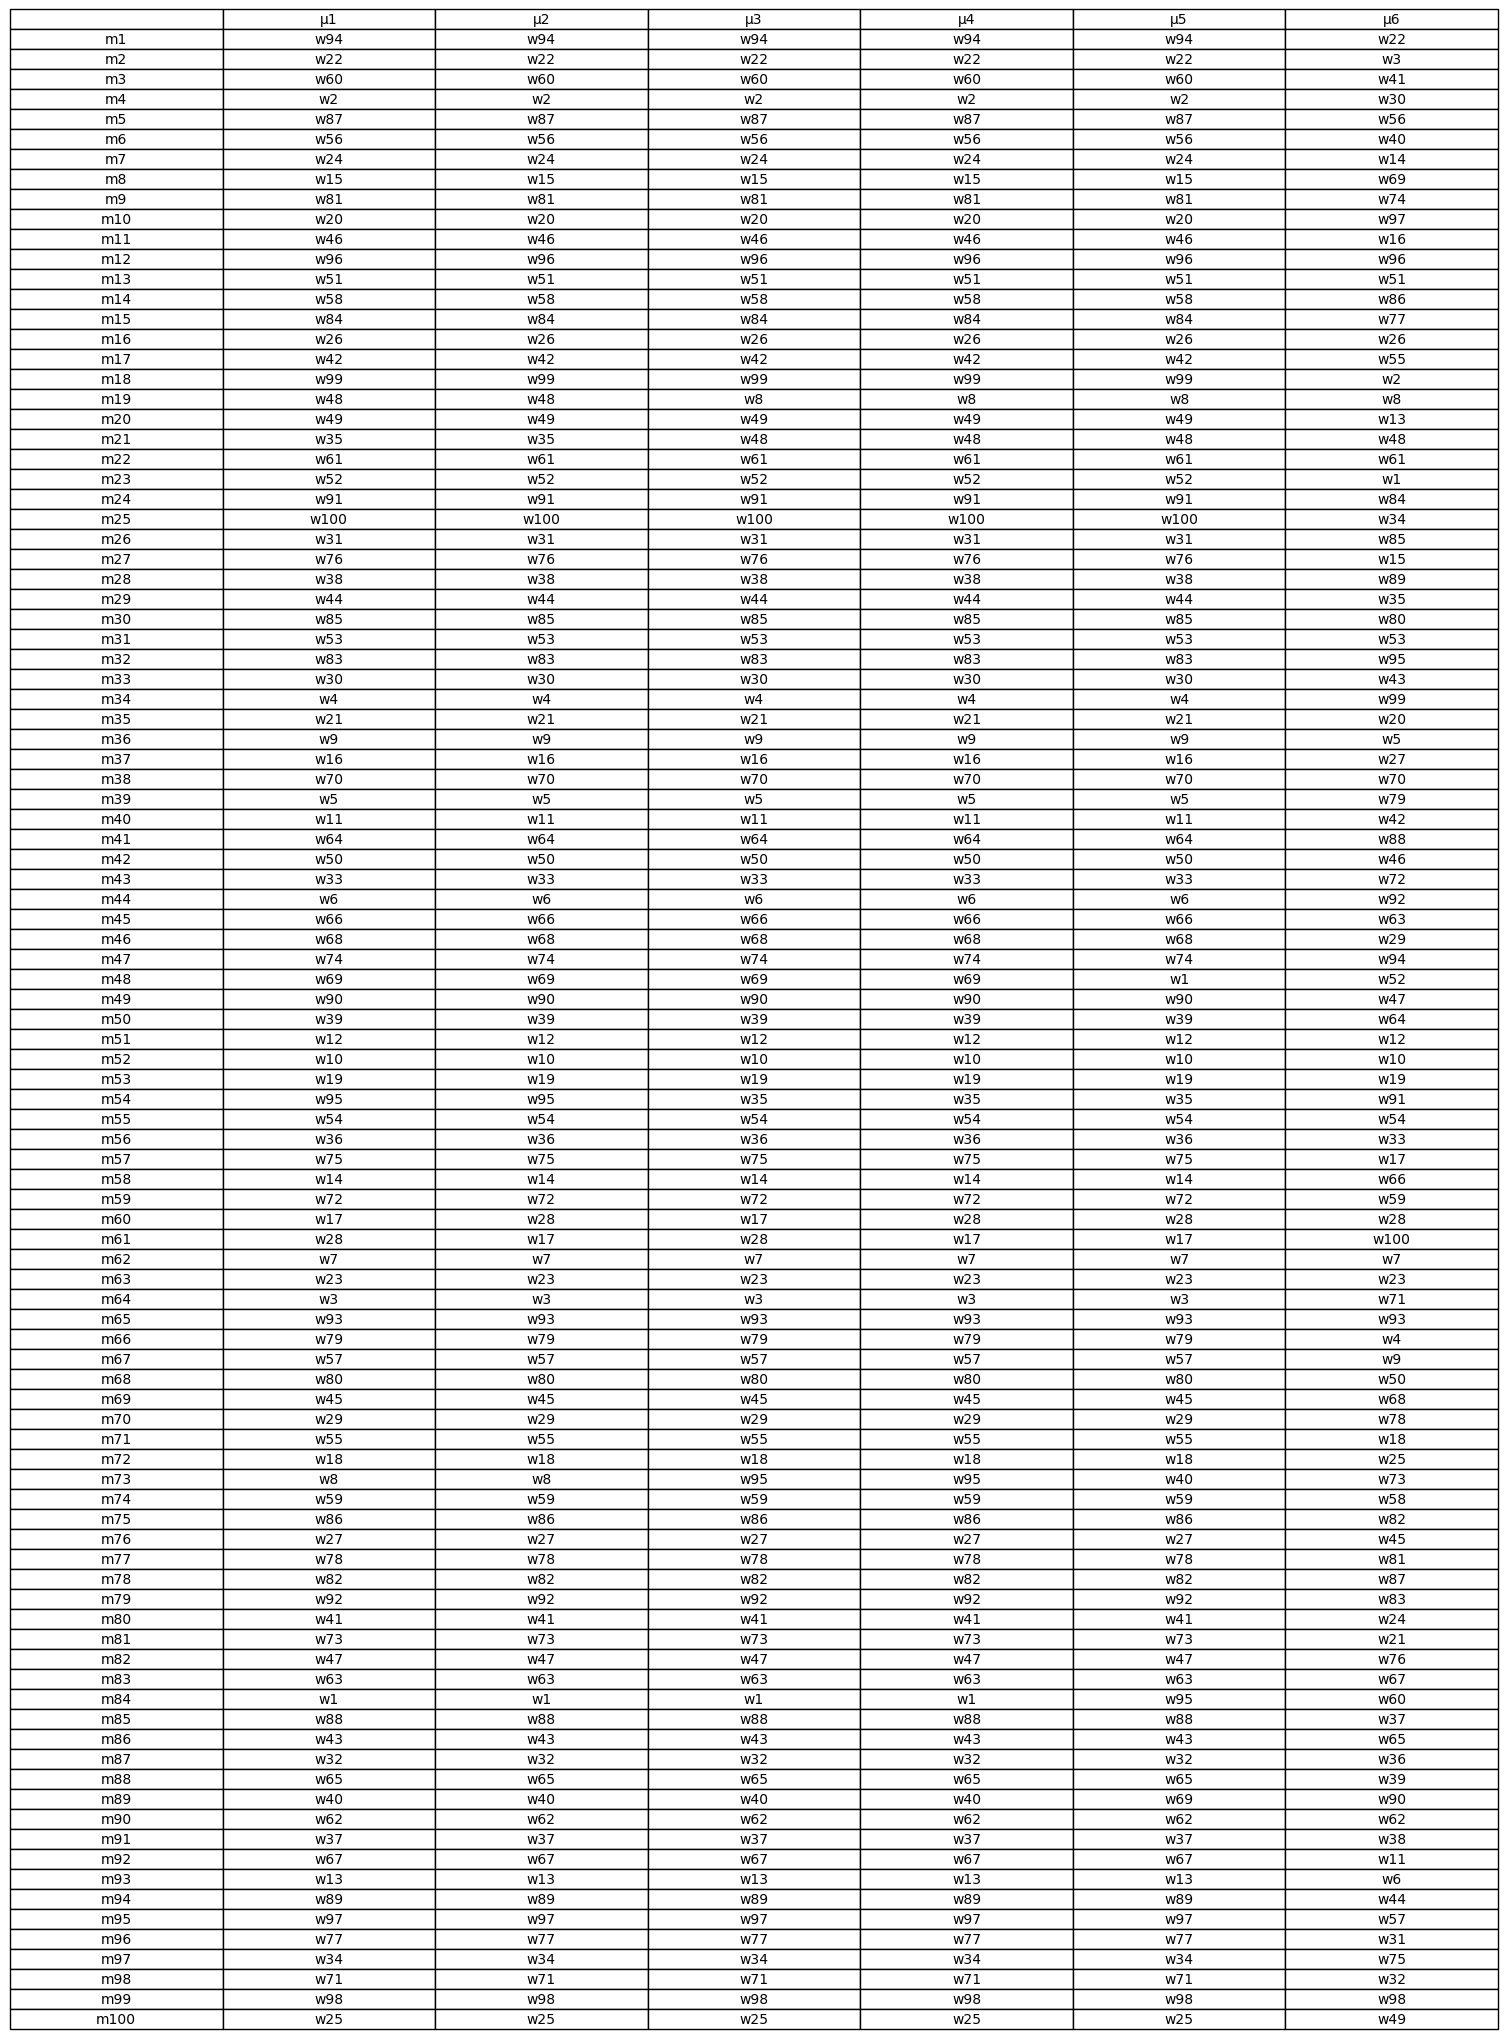

In [68]:
# replaces r with m and d with w
new_stable_matching = replace_keys_in_matchings(stable_matching)

# Show all stable matchings

result_df = create_aggregate_table(new_stable_matching)

col_labels = [' '] + [f'μ{i+1}' for i in range(len(stable_matching))]

fig, ax = plt.subplots(figsize=(16, 4))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=result_df.values, colLabels=col_labels, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2) 

plt.show()

In [69]:
import pandas as pd

results = []

for matching in stable_matching:
    recipient_preferences = []
    donor_preferences = []
    
    for pair, (recip_pref, donor_pref) in matching.items():
        recipient_preferences.append(recip_pref)
        donor_preferences.append(donor_pref)
    
    # Find the maximum man and woman preferences
    max_recipient_pref = max(recipient_preferences)
    max_donor_pref = max(donor_preferences)
    regret = max(max_recipient_pref, max_donor_pref)
    
    # Calculate the difference between the sum of men's preferences and the sum of women's preferences
    recipient_sum = sum(recipient_preferences)
    donor_sum = sum(donor_preferences)
    preference_diff = recipient_sum - donor_sum
    
    results.append({
        'd(μ)': preference_diff,
        'r(μ)': regret
    })

# Show the results
df = pd.DataFrame(results)
print(df)


   d(μ)  r(μ)
0 -2649    99
1 -2532    99
2 -2592    99
3 -2475    99
4 -2334    99
5  1469    84
